In [22]:
import pandas as pd
import math
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
from shapely.ops import nearest_points
import descartes
import numpy as np
from pyproj import Proj, transform
import scipy
from scipy.spatial import cKDTree
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
import seaborn as sn
import pysal as ps
from sklearn import cluster
from sklearn.preprocessing import scale
%matplotlib inline

In [2]:
#Asignación de localidad a terreno
cobertura = gpd.read_file('conjunto_de_datos/Cobertura/cobertura.shp')
terrenos = gpd.read_file('conjunto_de_datos/Terrenos/terrenos.shp')
terrenos.head()

,Title,Address,Descripcio,Precio,TamaÃ±o,Latitud,Longitud,Tamano,Precio/Tam,geometry
0,LagunasInterior . Punta TiburÃ³n Residencial; ...,Km. 4.5 Carretera Federal Boca del RÃ­o - AntÃ...,Punta tiburÃ³n residencial se encuentra en la ...,769500.0,180 mÂ²,19.067293,-96.080747,180.0,4275.000000,POINT (-96.08075 19.06729)
1,La Escondida Residencial â Terrenos,Octava Avenida y Veracruz||RincÃ³n de La Sierr...,La Escondida ResidencialResidencias y Lotes de...,711000.0,140 mÂ²,25.641346,-100.198342,140.0,5078.571429,POINT (-100.19834 25.64135)
2,El Molino Residencial & Golf,Paseos El Molino # 302; LeÃ³n; Gto||Balcones d...,El Molino; Residencial & GolfEs un impresionan...,845719.0,250 mÂ²,21.185639,-101.699237,250.0,3382.876000,POINT (-101.69924 21.18564)
3,Club Cenote Residencial,Ruta de los Cenotes Km 19 DesviaciÃ³n Delirios...,Club Cenote ResidencialAmplios Terrenos en el ...,1039000.0,800 mÂ²,20.847873,-87.220608,800.0,1298.750000,POINT (-87.22061 20.84787)
4,Punta TiburÃ³n Residencial; Marina & Golf - Bo...,Km. 4.5 Carretera Federal Boca del RÃ­o - AntÃ...,Punta tiburÃ³n residencial se encuentra en la ...,723672.0,180 mÂ²,19.067293,-96.080747,180.0,4020.400000,POINT (-96.08075 19.06729)


In [3]:
cobertura.head()

,ID,ID ENTIDAD,ENTIDAD,ID MUNICIP,MUNICIPIO,ID LOCALID,LOCALIDAD,longitud,latitud,altitud,Población,Clasificac,Rango,HAB_CUB_OP,HAB_SCOB_O,% COB OPER,COB OPERAD,Clave,geometry
0,10010001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1021746,215251,1885,722250,Localidad Mayor,a) > 10 mil,722250,0,1.0,SI,010010001,POINT (-102.29611 21.88083)
1,10010094,1,Aguascalientes,1,Aguascalientes,94,Granja Adelita,1022225,215219,1903,14,Localidad Menor,g)<500,14,0,1.0,SI,010010094,POINT (-102.37361 21.87194)
2,10010096,1,Aguascalientes,1,Aguascalientes,96,Agua Azul,1022127,215303,1863,37,Localidad Menor,g)<500,37,0,1.0,SI,010010096,POINT (-102.35750 21.88417)
3,10010100,1,Aguascalientes,1,Aguascalientes,100,Rancho Alegre,1022222,215116,1880,10,Localidad Menor,g)<500,10,0,1.0,SI,010010100,POINT (-102.37278 21.85444)
4,10010102,1,Aguascalientes,1,Aguascalientes,102,Los Arbolitos [Rancho],1022126,214649,1860,7,Localidad Menor,g)<500,7,0,1.0,SI,010010102,POINT (-102.35722 21.78028)


In [4]:
def ckdnearest(gdA, gdB):
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns == 'Clave'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

terrenos_loc = ckdnearest(terrenos, cobertura)

In [5]:
terrenos_loc.head()

,Title,Address,Descripcio,Precio,TamaÃ±o,Latitud,Longitud,Tamano,Precio/Tam,geometry,Clave,dist
0,LagunasInterior . Punta TiburÃ³n Residencial; ...,Km. 4.5 Carretera Federal Boca del RÃ­o - AntÃ...,Punta tiburÃ³n residencial se encuentra en la ...,769500.0,180 mÂ²,19.067293,-96.080747,180.0,4275.000000,POINT (-96.08075 19.06729),300110292,0.002173
1,La Escondida Residencial â Terrenos,Octava Avenida y Veracruz||RincÃ³n de La Sierr...,La Escondida ResidencialResidencias y Lotes de...,711000.0,140 mÂ²,25.641346,-100.198342,140.0,5078.571429,POINT (-100.19834 25.64135),190310045,0.015914
2,El Molino Residencial & Golf,Paseos El Molino # 302; LeÃ³n; Gto||Balcones d...,El Molino; Residencial & GolfEs un impresionan...,845719.0,250 mÂ²,21.185639,-101.699237,250.0,3382.876000,POINT (-101.69924 21.18564),110201198,0.001994
3,Club Cenote Residencial,Ruta de los Cenotes Km 19 DesviaciÃ³n Delirios...,Club Cenote ResidencialAmplios Terrenos en el ...,1039000.0,800 mÂ²,20.847873,-87.220608,800.0,1298.750000,POINT (-87.22061 20.84787),230070078,0.000190
4,Punta TiburÃ³n Residencial; Marina & Golf - Bo...,Km. 4.5 Carretera Federal Boca del RÃ­o - AntÃ...,Punta tiburÃ³n residencial se encuentra en la ...,723672.0,180 mÂ²,19.067293,-96.080747,180.0,4020.400000,POINT (-96.08075 19.06729),300110292,0.002173


In [6]:
locs_ter =terrenos_loc.groupby('Clave').mean().reset_index()
locs_ter.head()

,Clave,Precio,Latitud,Longitud,Tamano,Precio/Tam,dist
0,010010001,6213848.8,21.886016,-102.294572,881.6,6099.877565,0.008725
1,010010106,39250000.0,21.798480,-102.276770,34000.0,821.551724,0.003309
2,010010120,223672100.0,21.715990,-102.306005,446122.0,527.472577,0.013063
3,010010126,1800000.0,22.014230,-102.192930,10000.0,180.000000,0.008240
4,010010135,13993800.0,21.699490,-102.311850,5961.5,6341.248721,0.001018


In [7]:
cobertura = pd.merge(cobertura,locs_ter[['Precio/Tam','Clave']],how='left', on='Clave')

In [8]:
cobertura.head()

,ID,ID ENTIDAD,ENTIDAD,ID MUNICIP,MUNICIPIO,ID LOCALID,LOCALIDAD,longitud,latitud,altitud,Población,Clasificac,Rango,HAB_CUB_OP,HAB_SCOB_O,% COB OPER,COB OPERAD,Clave,geometry,Precio/Tam
0,10010001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1021746,215251,1885,722250,Localidad Mayor,a) > 10 mil,722250,0,1.0,SI,010010001,POINT (-102.29611 21.88083),6099.877565
1,10010094,1,Aguascalientes,1,Aguascalientes,94,Granja Adelita,1022225,215219,1903,14,Localidad Menor,g)<500,14,0,1.0,SI,010010094,POINT (-102.37361 21.87194),NaN
2,10010096,1,Aguascalientes,1,Aguascalientes,96,Agua Azul,1022127,215303,1863,37,Localidad Menor,g)<500,37,0,1.0,SI,010010096,POINT (-102.35750 21.88417),NaN
3,10010100,1,Aguascalientes,1,Aguascalientes,100,Rancho Alegre,1022222,215116,1880,10,Localidad Menor,g)<500,10,0,1.0,SI,010010100,POINT (-102.37278 21.85444),NaN
4,10010102,1,Aguascalientes,1,Aguascalientes,102,Los Arbolitos [Rancho],1022126,214649,1860,7,Localidad Menor,g)<500,7,0,1.0,SI,010010102,POINT (-102.35722 21.78028),NaN


In [9]:
cob_precio = cobertura[(~cobertura['Precio/Tam'].isna())]

In [10]:
estados = 'conjunto_de_datos/Estados/estados.shp'
mex = gpd.read_file(estados)
#mex

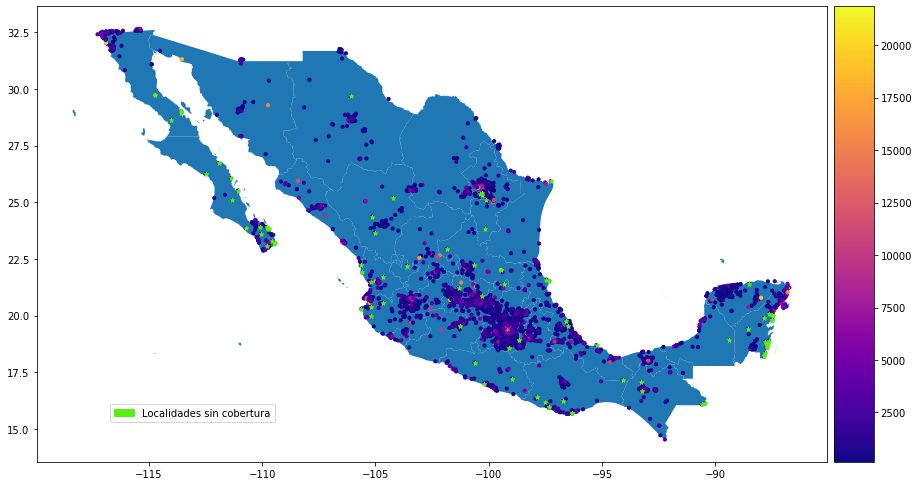

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mex.plot(ax=ax)
cob_precio.plot(ax=ax,markersize=10,column='Precio/Tam', legend=True,cax=cax, cmap='plasma')
cob_precio[cob_precio['COB OPERAD']=='NO'].plot(ax=ax, markersize=20, color='#58F011',marker='*',legend=True)
red_patch = mpatches.Patch(color='#58F011', label='Localidades sin cobertura')
plt.legend(handles=[red_patch],bbox_to_anchor=(.35, .35),bbox_transform=plt.gcf().transFigure)
#plt.scatter(cob_precio.geometry.x,cob_precio.geometry.y,c=cob_precio['COB OPERAD']=='SI', cmap = cm.RdYlGn)
plt.show()

In [12]:
cob_precio.head()

,ID,ID ENTIDAD,ENTIDAD,ID MUNICIP,MUNICIPIO,ID LOCALID,LOCALIDAD,longitud,latitud,altitud,Población,Clasificac,Rango,HAB_CUB_OP,HAB_SCOB_O,% COB OPER,COB OPERAD,Clave,geometry,Precio/Tam
0,10010001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1021746,215251,1885,722250,Localidad Mayor,a) > 10 mil,722250,0,1.0,SI,010010001,POINT (-102.29611 21.88083),6099.877565
6,10010106,1,Aguascalientes,1,Aguascalientes,106,Arellano,1021628,214803,1894,1382,Localidad Menor,"e)>1,000",1382,0,1.0,SI,010010106,POINT (-102.27444 21.80083),821.551724
9,10010120,1,Aguascalientes,1,Aguascalientes,120,Buenavista de Peñuelas,1021744,214303,1870,935,Localidad Menor,f)>500,935,0,1.0,SI,010010120,POINT (-102.29556 21.71750),527.472577
12,10010126,1,Aguascalientes,1,Aguascalientes,126,Cañada Honda [Estación],1021153,220028,1927,509,Localidad Menor,f)>500,509,0,1.0,SI,010010126,POINT (-102.19806 22.00778),180.000000
15,10010135,1,Aguascalientes,1,Aguascalientes,135,El Cedazo (Cedazo de San Antonio),1021839,214158,1859,234,Localidad Menor,g)<500,234,0,1.0,SI,010010135,POINT (-102.31083 21.69944),6341.248721


In [19]:
varis=['Clave', 'Población', '% COB OPER', 'Precio/Tam']

In [13]:
corrMatrix = cob_precio[['Población','% COB OPER','Precio/Tam']].corr()
#cob_

In [14]:
corrMatrix

,Población,% COB OPER,Precio/Tam
Población,1.000000,0.021656,0.186231
% COB OPER,0.021656,1.000000,0.019685
Precio/Tam,0.186231,0.019685,1.000000


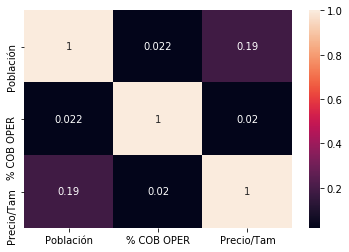

In [15]:
sn.heatmap(corrMatrix, annot=True)

In [16]:
cob_precio.groupby('% COB OPER').count()

,ID,ID ENTIDAD,ENTIDAD,ID MUNICIP,MUNICIPIO,ID LOCALID,LOCALIDAD,longitud,latitud,altitud,Población,Clasificac,Rango,HAB_CUB_OP,HAB_SCOB_O,COB OPERAD,Clave,geometry,Precio/Tam
% COB OPER,,,,,,,,,,,,,,,,,,,
0.000000,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90
0.999674,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1.000000,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563


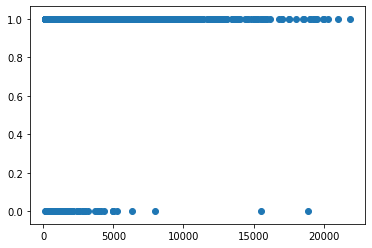

In [17]:
plt.scatter(cob_precio['Precio/Tam'], cob_precio['% COB OPER'])

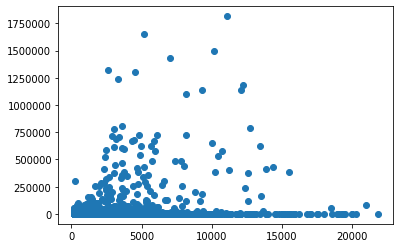

In [18]:
plt.scatter(cob_precio['Precio/Tam'], cob_precio['Población'])

In [27]:
db=cob_precio[varis]
db = db.set_index('Clave')
#db.head()
db = pd.DataFrame(scale(db), 
                 index=db.index, 
                 columns=db.columns).rename(lambda x: str(int(x)))

In [28]:
db

,Población,% COB OPER,Precio/Tam
Clave,,,
10010001,7.936368,0.140427,1.436839
10010106,-0.141494,0.140427,-0.586444
10010120,-0.146503,0.140427,-0.699171
10010126,-0.151277,0.140427,-0.832364
10010135,-0.154359,0.140427,1.529361
...,...,...,...
320560163,-0.156813,0.140427,1.599340
320560168,-0.156880,0.140427,2.187254
320560170,-0.156734,0.140427,-0.829489


In [29]:
km5 = cluster.KMeans(n_clusters=5)

In [30]:
km5cls = km5.fit(db.values)

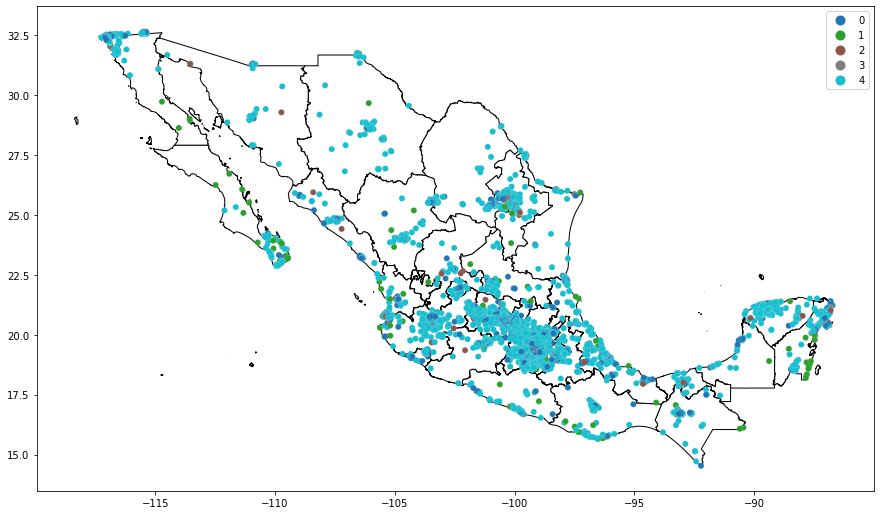

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
mex.plot(ax=ax,color='white',edgecolor='black')
cob_precio.assign(cl=km5cls.labels_).plot(column='cl', categorical=True, legend=True, 
         linewidth=0.1, edgecolor='white', ax=ax)

plt.show()


In [45]:
clusters = cob_precio.assign(cl=km5cls.labels_)

In [59]:
clusters.groupby('cl').mean()

,ID,ID ENTIDAD,ID MUNICIP,ID LOCALID,longitud,latitud,altitud,Población,HAB_CUB_OP,HAB_SCOB_O,% COB OPER,Precio/Tam
cl,,,,,,,,,,,,
0,1.717467e+08,17.133752,40.881508,351.006284,9.976204e+05,206892.556553,1371.152603,11491.655296,11491.600539,0.054758,1.0,4684.026089
1,1.574991e+08,15.700000,49.855556,517.522222,9.943577e+05,210413.088889,540.233333,246.144444,0.000000,246.144444,0.0,1985.760824
2,1.671019e+08,16.669355,40.814516,233.048387,1.005502e+06,212621.427419,1399.661290,30405.427419,30405.427419,0.000000,1.0,12762.233482
3,1.517642e+08,15.133333,43.088889,1.000000,1.006965e+06,220856.355556,1366.266667,783946.600000,783946.600000,0.000000,1.0,6166.299305
4,1.742875e+08,17.381591,47.132582,295.296861,9.970638e+05,210099.763487,1300.763792,4061.549528,4061.549528,0.000000,1.0,1123.738596


In [57]:
clusters.groupby('cl').count()

,ID,ID ENTIDAD,ENTIDAD,ID MUNICIP,MUNICIPIO,ID LOCALID,LOCALIDAD,longitud,latitud,altitud,Población,Clasificac,Rango,HAB_CUB_OP,HAB_SCOB_O,% COB OPER,COB OPERAD,Clave,geometry,Precio/Tam
cl,,,,,,,,,,,,,,,,,,,,
0,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114
1,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90
2,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124
3,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45
4,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281,3281
